Student 1: name: Moriel Tomchin, i.d.: 206970063, github: https://github.com/morielsh57/ML_intro_course

Student 2: Tal Rozman: , i.d.: 211680178, github: https://github.com/TalRozman/ML_intro_course

Student 3: Emma Hrinevitzky : , i.d.: 206385858 , github: https://github.com/emmahr1998/ML_intro_course

Libraries (don't change)

In [11]:
!pip -q install torchinfo

from dataclasses import dataclass
from typing import List, Callable, Optional, Tuple

import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchinfo import summary

from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
%matplotlib inline


Device (don't change)

In [12]:

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
use_amp = (DEVICE == "cuda")

print(f"Using device: {DEVICE}")
print(f"Mixed precision (AMP): {use_amp}")

Using device: cpu
Mixed precision (AMP): False


Data (don't change)

In [13]:

class DataManager:
    def __init__(self, dataset_class, root: str = "./data", val_fraction: float = 0.1,
                 batch_size: int = 32, seed: int = 42):
        self.dataset_class = dataset_class
        self.root = root
        self.val_fraction = val_fraction
        self.batch_size = batch_size
        self.seed = seed

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1918,), (0.3483,))
        ])

    def get_loaders(self) -> Tuple[DataLoader, DataLoader, DataLoader]:
        full_train = self.dataset_class(root=self.root, train=True,
                                        download=True, transform=self.transform)
        test_ds = self.dataset_class(root=self.root, train=False,
                                     download=True, transform=self.transform)

        val_size = int(len(full_train) * self.val_fraction)
        train_size = len(full_train) - val_size

        generator = torch.Generator().manual_seed(self.seed)
        train_ds, val_ds = random_split(full_train, [train_size, val_size], generator=generator)

        train_loader = DataLoader(train_ds, batch_size=self.batch_size,
                                  shuffle=True, num_workers=2, pin_memory=True)
        val_loader   = DataLoader(val_ds,   batch_size=self.batch_size,
                                  shuffle=False, num_workers=2, pin_memory=True)
        test_loader  = DataLoader(test_ds,  batch_size=self.batch_size,
                                  shuffle=False, num_workers=2, pin_memory=True)

        print(f"Train: {len(train_ds)} | Val: {len(val_ds)} | Test: {len(test_ds)}")
        return train_loader, val_loader, test_loader

Configurations (don't change)

In [14]:

@dataclass
class LayerSpec:
    out_dim: int
    activation: Callable[[torch.Tensor], torch.Tensor] = F.relu
    dropout: float = 0.0
    batch_norm: bool = True
    weight_decay: float = 0.0

@dataclass
class ModelConfig:
    input_dim: Tuple[int, int, int] = (1, 28, 28)
    num_classes: int = 10
    layers: List[LayerSpec] = None

@dataclass
class TrainConfig:
    batch_size: int = 64
    epochs: int = 100
    lr: float = 1e-4
    patience: int = 15
    min_delta: float = 1e-4
    val_fraction: float = 0.1
    seed: int = 42


Model

In [15]:

class MLPFromConfig(nn.Module):
    def __init__(self, config: ModelConfig):
        super().__init__()
        flat_dim = config.input_dim[0] * config.input_dim[1] * config.input_dim[2]
        self.layers_specs = config.layers
        layers = []
        prev_dim = flat_dim

        for i, spec in enumerate(config.layers):
            linear = nn.Linear(prev_dim, spec.out_dim)

            layers.append(linear)
            if spec.batch_norm:
                layers.append(nn.BatchNorm1d(spec.out_dim))
            if spec.dropout > 0:
                layers.append(nn.Dropout(spec.dropout))
            layers.append(spec.activation())
            prev_dim = spec.out_dim

        # Final classifier layer
        self.final_linear = nn.Linear(prev_dim, config.num_classes)
        layers.append(self.final_linear)

        self.net = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.view(x.size(0), -1)
        return self.net(x)

    def get_layer_params(self):
        param_groups = []
        for i, spec in enumerate(self.layers_specs):
            linear_layer = self.net[i * (4 if spec.batch_norm or spec.dropout > 0 else 3)]
            pass
        return self.layers_specs

Early Stopping (don't change)

In [16]:

class EarlyStopping:
    def __init__(self, patience: int = 10, min_delta: float = 1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.should_stop = False

    def __call__(self, val_loss: float) -> bool:
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True
        return self.should_stop

Trainer (don't change)

In [17]:

class Trainer:
    def __init__(self, model: nn.Module, config: TrainConfig):
        self.model = model.to(DEVICE)
        self.config = config
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = self._build_optimizer()
        self.scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
        self.early_stopping = EarlyStopping(patience=config.patience,
                                            min_delta=config.min_delta)

        self.history = {"train_loss": [], "train_acc": [],
                        "val_loss": [], "val_acc": []}

    def _build_optimizer(self):

        # Collect all Linear layers in the order they appear
        linear_layers = []
        for name, module in self.model.named_modules():
            if isinstance(module, nn.Linear):
                linear_layers.append((name, module))

        param_groups = []

        for i, spec in enumerate(self.model.layers_specs):
            name, layer = linear_layers[i]
            param_groups.append({
                'params': layer.parameters(),
                'weight_decay': spec.weight_decay
            })

        final_name, final_layer = linear_layers[-1]
        param_groups.append({
            'params': final_layer.parameters(),
            'weight_decay': 0.0
        })

        return torch.optim.SGD(param_groups, momentum=0.9, nesterov=True, lr=self.config.lr)

    def _train_epoch(self, loader: DataLoader):
        self.model.train()
        total_loss = 0.0
        correct = 0
        total = 0

        for data, target in loader:
            data, target = data.to(DEVICE), target.to(DEVICE)

            self.optimizer.zero_grad()
            with torch.cuda.amp.autocast(enabled=use_amp):
                output = self.model(data)
                loss = self.criterion(output, target)

            self.scaler.scale(loss).backward()
            self.scaler.step(self.optimizer)
            self.scaler.update()

            total_loss += loss.item() * data.size(0)
            correct += (output.argmax(1) == target).sum().item()
            total += data.size(0)

        return total_loss / total, correct / total

    @torch.no_grad()
    def _eval_epoch(self, loader: DataLoader):
        self.model.eval()
        total_loss = 0.0
        correct = 0
        total = 0

        for data, target in loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            with torch.cuda.amp.autocast(enabled=use_amp):
                output = self.model(data)
                loss = self.criterion(output, target)

            total_loss += loss.item() * data.size(0)
            correct += (output.argmax(1) == target).sum().item()
            total += data.size(0)

        return total_loss / total, correct / total

    def fit(self, train_loader: DataLoader, val_loader: DataLoader):
        print("🚀 Starting training...\n")
        for epoch in range(1, self.config.epochs + 1):
            train_loss, train_acc = self._train_epoch(train_loader)
            val_loss, val_acc     = self._eval_epoch(val_loader)

            self.history["train_loss"].append(train_loss)
            self.history["train_acc"].append(train_acc)
            self.history["val_loss"].append(val_loss)
            self.history["val_acc"].append(val_acc)

            print(f"Epoch {epoch:3d} | "
                  f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
                  f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

            if self.early_stopping(val_loss):
                print(f"\n🛑 Early stopping triggered at epoch {epoch}")
                break

        print("\n✅ Training complete!")

    @torch.no_grad()
    def evaluate(self, loader: DataLoader):
        return self._eval_epoch(loader)

    @torch.no_grad()
    def predict_all(self, loader: DataLoader):
        self.model.eval()
        all_preds, all_targets = [], []
        for x, y in loader:
            x = x.to(DEVICE, non_blocking=True)
            logits = self.model(x)
            preds = logits.argmax(dim=1).cpu().numpy()
            all_preds.append(preds)
            all_targets.append(y.numpy())
        return np.concatenate(all_preds), np.concatenate(all_targets)


    def save(self, path: str = "mlp_best.pt"):
        torch.save(self.model.state_dict(), path)
        print(f"💾 Model saved to {path}")



Run (do change)

In [ ]:
!pip -q install mlflow

import mlflow
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support
import os
from google.colab import files

def calculate_metrics(trainer, loader, prefix):
    preds, targets = trainer.predict_all(loader)

    precision, recall, f1, _ = precision_recall_fscore_support(
        targets, preds, average='macro', zero_division=0
    )

    return {
        f"{prefix}_Precision": precision,
        f"{prefix}_Recall": recall,
        f"{prefix}_F1": f1
    }

def run_experiment(exp_name, train_cfg, model_cfg,run_name=None):
    mlflow.set_experiment(exp_name)
    timestamp = time.strftime("%Y%m%d-%H%M%S")
    run_name = run_name or f"Run_{timestamp}"

    data_mgr = DataManager(
        dataset_class=datasets.KMNIST,
        val_fraction=train_cfg.val_fraction,
        batch_size=train_cfg.batch_size,
        seed=train_cfg.seed
    )
    train_loader, val_loader, test_loader = data_mgr.get_loaders()

    # Build model
    model = MLPFromConfig(model_cfg)
    trainer = Trainer(model, train_cfg)
    print(summary(model, input_size=(1, 28, 28)))

    with mlflow.start_run(run_name=run_name):
        params_to_log = {
                "epochs": train_cfg.epochs,
                "batch_size": train_cfg.batch_size,
                "lr": train_cfg.lr,
                "seed": train_cfg.seed,
                "optimizer": "SGD",
                "layers_count": len(model_cfg.layers)
            }
        mlflow.log_params(params_to_log)

        trainer.fit(train_loader, val_loader)
        model_filename = f"{run_name}_model.pt"
        trainer.save(model_filename)

        if os.path.exists(model_filename):
            print(f"Uploading {model_filename} to MLflow...")
            mlflow.log_artifact(model_filename)
        else:
            print(f"⚠️ Error: Could not find {model_filename}, skipping upload.")

        mlflow.log_params(params_to_log)
        train_metrics = calculate_metrics(trainer, train_loader, "Train")
        test_metrics = calculate_metrics(trainer, test_loader, "Test")
        all_metrics = {**train_metrics, **test_metrics}
        mlflow.log_metrics(all_metrics)
        mlflow.log_artifact(f"{run_name}_model.pt")

        excel_row = {"Run_Name": run_name}
        excel_row.update(params_to_log)
        excel_row.update(all_metrics)
        return {"data":excel_row,"trainer":trainer,"test_loader":test_loader}


experiments_data = []

cfg_1 = TrainConfig(
    batch_size=128,
    epochs=100,
    lr=1e-2,
    patience=5,
    val_fraction=0.1)
model_cfg_1 = ModelConfig(layers=[
    LayerSpec(out_dim=1024, dropout=0.2, activation=nn.ReLU, weight_decay=1e-5),
    LayerSpec(out_dim=512, dropout=0.2, activation=nn.ReLU, weight_decay=1e-5),
    LayerSpec(out_dim=256, dropout=0.2, activation=nn.ReLU, weight_decay=1e-5)
])
experiments_data.append(run_experiment("KMNIST_Final_HW", cfg_1, model_cfg_1, "Exp_1"))


cfg_2 = TrainConfig(
    batch_size=128,
    epochs=100,
    lr=1e-4,
    patience=5,
    val_fraction=0.1)
model_cfg_2 = ModelConfig(layers=[
    LayerSpec(out_dim=512, dropout=0.2, batch_norm=True, activation=nn.ReLU, weight_decay=1e-5),
    LayerSpec(out_dim=256,  dropout=0.4, batch_norm=True, activation=nn.ReLU, weight_decay=1e-4),
    LayerSpec(out_dim=128, batch_norm=True, activation = nn.ReLU, weight_decay=5e-1),
])
experiments_data.append(run_experiment("KMNIST_Final_HW", cfg_2, model_cfg_2, "Exp_2"))


cfg_3 = TrainConfig(
    batch_size=128,
    epochs=100,
    lr=1e-4,
    patience=5,
    val_fraction=0.1)
model_cfg_3 = ModelConfig(layers=[
    LayerSpec(out_dim=128, dropout=0.2, batch_norm=True, activation=nn.ReLU, weight_decay=1e-3),
    LayerSpec(out_dim=64,  dropout=0.1, batch_norm=False, activation=nn.ReLU, weight_decay=1e-4),
    LayerSpec(out_dim=10,  dropout=0.1, batch_norm=False, activation = nn.ReLU, weight_decay=5e-1),
])
experiments_data.append(run_experiment("KMNIST_Final_HW", cfg_3, model_cfg_3, "Exp_3"))


cfg_4 = TrainConfig(
    batch_size=128,
    epochs=100,
    lr=1e-4,
    patience=5,
    val_fraction=0.1)
model_cfg_4 = ModelConfig(layers=[
    LayerSpec(out_dim=1024, dropout=0.5, batch_norm=True, activation=nn.ReLU, weight_decay=1e-4),
    LayerSpec(out_dim=1024, dropout=0.5, batch_norm=True, activation=nn.ReLU, weight_decay=1e-4),
    LayerSpec(out_dim=512, dropout=0.2, batch_norm=True, activation=nn.ReLU, weight_decay=1e-4),
    LayerSpec(out_dim=256, dropout=0.1, batch_norm=True, activation=nn.ReLU),
])
experiments_data.append(run_experiment("KMNIST_Final_HW", cfg_4, model_cfg_4, "Exp_4"))


cfg_5 = TrainConfig(
    batch_size=128,
    epochs=100,
    lr= 1e-3,
    patience= 15,
    val_fraction=0.1)
model_cfg_5 = ModelConfig(layers=[
    LayerSpec(out_dim=1024, dropout=0.3, batch_norm=True, activation=nn.ReLU, weight_decay=1e-5),
    LayerSpec(out_dim=1024, dropout=0.3, batch_norm=True, activation=nn.ReLU, weight_decay=1e-5),
    LayerSpec(out_dim=512, dropout=0.2, batch_norm=True, activation=nn.ReLU, weight_decay=1e-6),
    LayerSpec(out_dim=256, dropout=0.1, batch_norm=True, activation=nn.ReLU),
])
experiments_data.append(run_experiment("KMNIST_Final_HW", cfg_5, model_cfg_5, "Exp_5"))


cfg_6 = TrainConfig(
    batch_size=128,
    epochs=100,
    lr= 1e-2,
    patience= 15,
    val_fraction=0.1)
model_cfg_6 = ModelConfig(layers=[
    LayerSpec(out_dim=1024, dropout=0.4, batch_norm=True, activation=nn.ReLU, weight_decay=1e-5),
    LayerSpec(out_dim=1024, dropout=0.4, batch_norm=True, activation=nn.ReLU, weight_decay=1e-5),
    LayerSpec(out_dim=512, dropout=0.2, batch_norm=True, activation=nn.ReLU, weight_decay=1e-5),
    LayerSpec(out_dim=256, dropout=0.0, batch_norm=True, activation=nn.ReLU),
])
experiments_data.append(run_experiment("KMNIST_Final_HW", cfg_6, model_cfg_6, "Exp_6"))


cfg_7 = TrainConfig(
    batch_size=128,
    epochs=100,
    lr= 5e-3,
    patience= 15,
    val_fraction=0.1)
model_cfg_7 = ModelConfig(layers=[
    LayerSpec(out_dim=1024, dropout=0.4, batch_norm=True, activation=nn.ReLU, weight_decay=1e-5),
    LayerSpec(out_dim=1024, dropout=0.4, batch_norm=True, activation=nn.ReLU, weight_decay=1e-5),
    LayerSpec(out_dim=512, dropout=0.2, batch_norm=True, activation=nn.ReLU, weight_decay=1e-5),
    LayerSpec(out_dim=256, dropout=0.0, batch_norm=True, activation=nn.ReLU),
])
experiments_data.append(run_experiment("KMNIST_Final_HW", cfg_7, model_cfg_7, "Exp_7"))


cfg_8 = TrainConfig(
    batch_size=128,
    epochs=100,
    lr= 7e-3,
    patience= 15,
    val_fraction=0.1)
model_cfg_8 = ModelConfig(layers=[
    LayerSpec(out_dim=1024, dropout=0.5, batch_norm=True, activation=nn.ReLU, weight_decay=5e-4),
    LayerSpec(out_dim=1024, dropout=0.5, batch_norm=True, activation=nn.ReLU, weight_decay=5e-4),
    LayerSpec(out_dim=512, dropout=0.3, batch_norm=True, activation=nn.ReLU, weight_decay=5e-4),
    LayerSpec(out_dim=256, dropout=0.1, batch_norm=True, activation=nn.ReLU),
])
experiments_data.append(run_experiment("KMNIST_Final_HW", cfg_8, model_cfg_8, "Exp_8"))


cfg_9 = TrainConfig(
    batch_size=128,
    epochs=100,
    patience= 15,
    lr=1e-3,
    val_fraction=0.1)
model_cfg_9 = ModelConfig(layers=[
    LayerSpec(out_dim=1024, dropout=0.5, batch_norm=True, activation=nn.ReLU, weight_decay=1e-4),
    LayerSpec(out_dim=1024, dropout=0.4, batch_norm=True, activation=nn.ReLU, weight_decay=1e-4),
    LayerSpec(out_dim=512, dropout=0.2, batch_norm=True, activation=nn.ReLU, weight_decay=1e-4),
    LayerSpec(out_dim=256, dropout=0.0, batch_norm=True, activation=nn.ReLU),
])
experiments_data.append(run_experiment("KMNIST_Final_HW", cfg_9, model_cfg_9, "Exp_9"))


cfg_10 = TrainConfig(
    batch_size=128,
    epochs=100,
    lr=1e-3,
    patience=7,
    val_fraction=0.1)
model_cfg_10 = ModelConfig(layers=[
    LayerSpec(out_dim=512, dropout=0.3, batch_norm=True,  activation=nn.ReLU, weight_decay=1e-4),
    LayerSpec(out_dim=256, dropout=0.2, batch_norm=True,  activation=nn.ReLU, weight_decay=1e-4),
    LayerSpec(out_dim=128, dropout=0.1, batch_norm=False, activation=nn.ReLU, weight_decay=1e-4),
])
experiments_data.append(run_experiment("KMNIST_Final_HW", cfg_10, model_cfg_10, "Exp_10"))


cfg_11 = TrainConfig(
    batch_size=128,
    epochs=100,
    lr=1e-3,
    patience=7,
    val_fraction=0.1)
model_cfg_11 = ModelConfig(layers=[
    LayerSpec(out_dim=512, dropout=0.3, batch_norm=True,  activation=nn.ReLU, weight_decay=1e-4),
    LayerSpec(out_dim=256, dropout=0.2, batch_norm=True,  activation=nn.ReLU, weight_decay=1e-4),
    LayerSpec(out_dim=128, dropout=0.1, batch_norm=False, activation=nn.ReLU, weight_decay=1e-4),
    LayerSpec(out_dim=10,  dropout=0.0, batch_norm=False, activation=nn.ReLU, weight_decay=0.0),
])
experiments_data.append(run_experiment("KMNIST_Final_HW", cfg_11, model_cfg_11, "Exp_11"))


cfg_12 = TrainConfig(
    batch_size=128,
    epochs=100,
    lr=1e-3,
    patience=7,
    val_fraction=0.1)
model_cfg_12 = ModelConfig(layers=[
    LayerSpec(out_dim=512, dropout=0.3, batch_norm=True,  activation=nn.ReLU, weight_decay=1e-4),
    LayerSpec(out_dim=256, dropout=0.2, batch_norm=True,  activation=nn.ReLU, weight_decay=1e-4),
    LayerSpec(out_dim=128, dropout=0.1, batch_norm=True, activation=nn.ReLU, weight_decay=1e-4),
    LayerSpec(out_dim=10,  dropout=0.0, batch_norm=False, activation=nn.ReLU, weight_decay=0.0),
])
experiments_data.append(run_experiment("KMNIST_Final_HW", cfg_12, model_cfg_12, "Exp_12"))



df_results = pd.DataFrame([item["data"] for item in experiments_data])
cols = ['Run_Name', 'Train_F1', 'Test_F1', 'Train_Precision', 'Test_Precision', 'Train_Recall', 'Test_Recall']
cols += [c for c in df_results.columns if c not in cols]
df_results = df_results[cols]

output_file = "experiment_results.xlsx"
df_results.to_excel(output_file, index=False)
files.download(output_file)

print(f"\n💾 Excel file saved to: {output_file}")
df_results.head(15)

Train: 54000 | Val: 6000 | Test: 10000
Layer (type:depth-idx)                   Output Shape              Param #
MLPFromConfig                            [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Linear: 2-1                       [1, 1024]                 803,840
│    └─BatchNorm1d: 2-2                  [1, 1024]                 2,048
│    └─Dropout: 2-3                      [1, 1024]                 --
│    └─ReLU: 2-4                         [1, 1024]                 --
│    └─Linear: 2-5                       [1, 512]                  524,800
│    └─BatchNorm1d: 2-6                  [1, 512]                  1,024
│    └─Dropout: 2-7                      [1, 512]                  --
│    └─ReLU: 2-8                         [1, 512]                  --
│    └─Linear: 2-9                       [1, 256]                  131,328
│    └─BatchNorm1d: 2-10                 [1, 256]                  512
│    └─Dropout: 2-11    

Epoch   1 | Train Loss: 0.4471 Acc: 0.8641 | Val Loss: 0.2024 Acc: 0.9368
Epoch   2 | Train Loss: 0.1963 Acc: 0.9394 | Val Loss: 0.1552 Acc: 0.9522
Epoch   3 | Train Loss: 0.1410 Acc: 0.9561 | Val Loss: 0.1388 Acc: 0.9560
Epoch   4 | Train Loss: 0.1099 Acc: 0.9644 | Val Loss: 0.1310 Acc: 0.9590
Epoch   5 | Train Loss: 0.0884 Acc: 0.9717 | Val Loss: 0.1179 Acc: 0.9665
Epoch   6 | Train Loss: 0.0757 Acc: 0.9761 | Val Loss: 0.1200 Acc: 0.9633
Epoch   7 | Train Loss: 0.0611 Acc: 0.9807 | Val Loss: 0.1201 Acc: 0.9638
Epoch   8 | Train Loss: 0.0537 Acc: 0.9829 | Val Loss: 0.1182 Acc: 0.9650
Epoch   9 | Train Loss: 0.0480 Acc: 0.9846 | Val Loss: 0.1179 Acc: 0.9655
Epoch  10 | Train Loss: 0.0452 Acc: 0.9850 | Val Loss: 0.1197 Acc: 0.9665

🛑 Early stopping triggered at epoch 10

✅ Training complete!
💾 Model saved to Exp_1_model.pt
Uploading Exp_1_model.pt to MLflow...


Train: 54000 | Val: 6000 | Test: 10000
Layer (type:depth-idx)                   Output Shape              Param #
MLPFromConfig                            [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Linear: 2-1                       [1, 512]                  401,920
│    └─BatchNorm1d: 2-2                  [1, 512]                  1,024
│    └─Dropout: 2-3                      [1, 512]                  --
│    └─ReLU: 2-4                         [1, 512]                  --
│    └─Linear: 2-5                       [1, 256]                  131,328
│    └─BatchNorm1d: 2-6                  [1, 256]                  512
│    └─Dropout: 2-7                      [1, 256]                  --
│    └─ReLU: 2-8                         [1, 256]                  --
│    └─Linear: 2-9                       [1, 128]                  32,896
│    └─BatchNorm1d: 2-10                 [1, 128]                  256
│    └─ReLU: 2-11          

Epoch   1 | Train Loss: 2.1269 Acc: 0.2741 | Val Loss: 1.8469 Acc: 0.5953
Epoch   2 | Train Loss: 1.7239 Acc: 0.5475 | Val Loss: 1.4846 Acc: 0.6918
Epoch   3 | Train Loss: 1.4403 Acc: 0.6485 | Val Loss: 1.2438 Acc: 0.7268
Epoch   4 | Train Loss: 1.2279 Acc: 0.7001 | Val Loss: 1.0571 Acc: 0.7600
Epoch   5 | Train Loss: 1.0683 Acc: 0.7357 | Val Loss: 0.9127 Acc: 0.7827
Epoch   6 | Train Loss: 0.9414 Acc: 0.7647 | Val Loss: 0.7974 Acc: 0.8092
Epoch   7 | Train Loss: 0.8341 Acc: 0.7920 | Val Loss: 0.7005 Acc: 0.8313
Epoch   8 | Train Loss: 0.7435 Acc: 0.8124 | Val Loss: 0.6192 Acc: 0.8473
Epoch   9 | Train Loss: 0.6688 Acc: 0.8309 | Val Loss: 0.5514 Acc: 0.8630
Epoch  10 | Train Loss: 0.6060 Acc: 0.8457 | Val Loss: 0.4976 Acc: 0.8758
Epoch  11 | Train Loss: 0.5532 Acc: 0.8589 | Val Loss: 0.4481 Acc: 0.8867
Epoch  12 | Train Loss: 0.5100 Acc: 0.8673 | Val Loss: 0.4113 Acc: 0.8957
Epoch  13 | Train Loss: 0.4752 Acc: 0.8747 | Val Loss: 0.3818 Acc: 0.9012
Epoch  14 | Train Loss: 0.4465 Acc: 0.

Train: 54000 | Val: 6000 | Test: 10000
Layer (type:depth-idx)                   Output Shape              Param #
MLPFromConfig                            [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Linear: 2-1                       [1, 128]                  100,480
│    └─BatchNorm1d: 2-2                  [1, 128]                  256
│    └─Dropout: 2-3                      [1, 128]                  --
│    └─ReLU: 2-4                         [1, 128]                  --
│    └─Linear: 2-5                       [1, 64]                   8,256
│    └─Dropout: 2-6                      [1, 64]                   --
│    └─ReLU: 2-7                         [1, 64]                   --
│    └─Linear: 2-8                       [1, 10]                   650
│    └─Dropout: 2-9                      [1, 10]                   --
│    └─ReLU: 2-10                        [1, 10]                   --
│    └─Linear: 2-11                 

Epoch   1 | Train Loss: 2.3139 Acc: 0.1074 | Val Loss: 2.3009 Acc: 0.1033
Epoch   2 | Train Loss: 2.2981 Acc: 0.1192 | Val Loss: 2.2882 Acc: 0.1228
Epoch   3 | Train Loss: 2.2875 Acc: 0.1367 | Val Loss: 2.2791 Acc: 0.1498
Epoch   4 | Train Loss: 2.2795 Acc: 0.1544 | Val Loss: 2.2710 Acc: 0.1752
Epoch   5 | Train Loss: 2.2716 Acc: 0.1669 | Val Loss: 2.2634 Acc: 0.1865
Epoch   6 | Train Loss: 2.2642 Acc: 0.1746 | Val Loss: 2.2552 Acc: 0.1940
Epoch   7 | Train Loss: 2.2554 Acc: 0.1826 | Val Loss: 2.2459 Acc: 0.2000
Epoch   8 | Train Loss: 2.2451 Acc: 0.1895 | Val Loss: 2.2347 Acc: 0.2072
Epoch   9 | Train Loss: 2.2335 Acc: 0.1981 | Val Loss: 2.2225 Acc: 0.2135
Epoch  10 | Train Loss: 2.2213 Acc: 0.2078 | Val Loss: 2.2087 Acc: 0.2262
Epoch  11 | Train Loss: 2.2067 Acc: 0.2209 | Val Loss: 2.1926 Acc: 0.2442
Epoch  12 | Train Loss: 2.1905 Acc: 0.2343 | Val Loss: 2.1753 Acc: 0.2588
Epoch  13 | Train Loss: 2.1723 Acc: 0.2463 | Val Loss: 2.1545 Acc: 0.2722
Epoch  14 | Train Loss: 2.1517 Acc: 0.

Train: 54000 | Val: 6000 | Test: 10000
Layer (type:depth-idx)                   Output Shape              Param #
MLPFromConfig                            [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Linear: 2-1                       [1, 1024]                 803,840
│    └─BatchNorm1d: 2-2                  [1, 1024]                 2,048
│    └─Dropout: 2-3                      [1, 1024]                 --
│    └─ReLU: 2-4                         [1, 1024]                 --
│    └─Linear: 2-5                       [1, 1024]                 1,049,600
│    └─BatchNorm1d: 2-6                  [1, 1024]                 2,048
│    └─Dropout: 2-7                      [1, 1024]                 --
│    └─ReLU: 2-8                         [1, 1024]                 --
│    └─Linear: 2-9                       [1, 512]                  524,800
│    └─BatchNorm1d: 2-10                 [1, 512]                  1,024
│    └─Dropout: 2-11

Epoch   1 | Train Loss: 2.2515 Acc: 0.1712 | Val Loss: 2.0711 Acc: 0.4825
Epoch   2 | Train Loss: 2.0165 Acc: 0.3440 | Val Loss: 1.8077 Acc: 0.6043
Epoch   3 | Train Loss: 1.7701 Acc: 0.4790 | Val Loss: 1.5425 Acc: 0.6528
Epoch   4 | Train Loss: 1.5424 Acc: 0.5644 | Val Loss: 1.3006 Acc: 0.6880
Epoch   5 | Train Loss: 1.3583 Acc: 0.6174 | Val Loss: 1.1287 Acc: 0.7097
Epoch   6 | Train Loss: 1.2159 Acc: 0.6533 | Val Loss: 0.9990 Acc: 0.7290
Epoch   7 | Train Loss: 1.1084 Acc: 0.6797 | Val Loss: 0.8971 Acc: 0.7482
Epoch   8 | Train Loss: 1.0217 Acc: 0.7014 | Val Loss: 0.8151 Acc: 0.7620
Epoch   9 | Train Loss: 0.9570 Acc: 0.7157 | Val Loss: 0.7636 Acc: 0.7717
Epoch  10 | Train Loss: 0.9020 Acc: 0.7301 | Val Loss: 0.7087 Acc: 0.7838
Epoch  11 | Train Loss: 0.8570 Acc: 0.7420 | Val Loss: 0.6689 Acc: 0.7935
Epoch  12 | Train Loss: 0.8175 Acc: 0.7522 | Val Loss: 0.6410 Acc: 0.8008
Epoch  13 | Train Loss: 0.7844 Acc: 0.7607 | Val Loss: 0.6095 Acc: 0.8093
Epoch  14 | Train Loss: 0.7517 Acc: 0.

Train: 54000 | Val: 6000 | Test: 10000
Layer (type:depth-idx)                   Output Shape              Param #
MLPFromConfig                            [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Linear: 2-1                       [1, 1024]                 803,840
│    └─BatchNorm1d: 2-2                  [1, 1024]                 2,048
│    └─Dropout: 2-3                      [1, 1024]                 --
│    └─ReLU: 2-4                         [1, 1024]                 --
│    └─Linear: 2-5                       [1, 1024]                 1,049,600
│    └─BatchNorm1d: 2-6                  [1, 1024]                 2,048
│    └─Dropout: 2-7                      [1, 1024]                 --
│    └─ReLU: 2-8                         [1, 1024]                 --
│    └─Linear: 2-9                       [1, 512]                  524,800
│    └─BatchNorm1d: 2-10                 [1, 512]                  1,024
│    └─Dropout: 2-11

Epoch   1 | Train Loss: 1.1462 Acc: 0.6656 | Val Loss: 0.5420 Acc: 0.8332
Epoch   2 | Train Loss: 0.5448 Acc: 0.8378 | Val Loss: 0.3708 Acc: 0.8850
Epoch   3 | Train Loss: 0.4147 Acc: 0.8735 | Val Loss: 0.2973 Acc: 0.9073
Epoch   4 | Train Loss: 0.3494 Acc: 0.8938 | Val Loss: 0.2613 Acc: 0.9178
Epoch   5 | Train Loss: 0.3063 Acc: 0.9063 | Val Loss: 0.2335 Acc: 0.9280
Epoch   6 | Train Loss: 0.2729 Acc: 0.9166 | Val Loss: 0.2118 Acc: 0.9375
Epoch   7 | Train Loss: 0.2484 Acc: 0.9238 | Val Loss: 0.2025 Acc: 0.9387
Epoch   8 | Train Loss: 0.2267 Acc: 0.9298 | Val Loss: 0.1851 Acc: 0.9438
Epoch   9 | Train Loss: 0.2092 Acc: 0.9353 | Val Loss: 0.1748 Acc: 0.9490
Epoch  10 | Train Loss: 0.1937 Acc: 0.9404 | Val Loss: 0.1695 Acc: 0.9473
Epoch  11 | Train Loss: 0.1831 Acc: 0.9431 | Val Loss: 0.1667 Acc: 0.9505
Epoch  12 | Train Loss: 0.1741 Acc: 0.9463 | Val Loss: 0.1568 Acc: 0.9532
Epoch  13 | Train Loss: 0.1614 Acc: 0.9497 | Val Loss: 0.1518 Acc: 0.9535
Epoch  14 | Train Loss: 0.1522 Acc: 0.

Train: 54000 | Val: 6000 | Test: 10000
Layer (type:depth-idx)                   Output Shape              Param #
MLPFromConfig                            [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Linear: 2-1                       [1, 1024]                 803,840
│    └─BatchNorm1d: 2-2                  [1, 1024]                 2,048
│    └─Dropout: 2-3                      [1, 1024]                 --
│    └─ReLU: 2-4                         [1, 1024]                 --
│    └─Linear: 2-5                       [1, 1024]                 1,049,600
│    └─BatchNorm1d: 2-6                  [1, 1024]                 2,048
│    └─Dropout: 2-7                      [1, 1024]                 --
│    └─ReLU: 2-8                         [1, 1024]                 --
│    └─Linear: 2-9                       [1, 512]                  524,800
│    └─BatchNorm1d: 2-10                 [1, 512]                  1,024
│    └─Dropout: 2-11

Epoch   1 | Train Loss: 0.5611 Acc: 0.8233 | Val Loss: 0.2499 Acc: 0.9227
Epoch   2 | Train Loss: 0.2727 Acc: 0.9142 | Val Loss: 0.1851 Acc: 0.9453
Epoch   3 | Train Loss: 0.2144 Acc: 0.9328 | Val Loss: 0.1589 Acc: 0.9518
Epoch   4 | Train Loss: 0.1801 Acc: 0.9427 | Val Loss: 0.1418 Acc: 0.9593
Epoch   5 | Train Loss: 0.1565 Acc: 0.9503 | Val Loss: 0.1361 Acc: 0.9585
Epoch   6 | Train Loss: 0.1380 Acc: 0.9567 | Val Loss: 0.1277 Acc: 0.9615
Epoch   7 | Train Loss: 0.1238 Acc: 0.9603 | Val Loss: 0.1268 Acc: 0.9620
Epoch   8 | Train Loss: 0.1147 Acc: 0.9631 | Val Loss: 0.1163 Acc: 0.9647
Epoch   9 | Train Loss: 0.1052 Acc: 0.9666 | Val Loss: 0.1225 Acc: 0.9635
Epoch  10 | Train Loss: 0.0941 Acc: 0.9691 | Val Loss: 0.1130 Acc: 0.9663
Epoch  11 | Train Loss: 0.0923 Acc: 0.9703 | Val Loss: 0.1123 Acc: 0.9675
Epoch  12 | Train Loss: 0.0786 Acc: 0.9746 | Val Loss: 0.1152 Acc: 0.9662
Epoch  13 | Train Loss: 0.0771 Acc: 0.9746 | Val Loss: 0.1103 Acc: 0.9682
Epoch  14 | Train Loss: 0.0692 Acc: 0.

Train: 54000 | Val: 6000 | Test: 10000
Layer (type:depth-idx)                   Output Shape              Param #
MLPFromConfig                            [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Linear: 2-1                       [1, 1024]                 803,840
│    └─BatchNorm1d: 2-2                  [1, 1024]                 2,048
│    └─Dropout: 2-3                      [1, 1024]                 --
│    └─ReLU: 2-4                         [1, 1024]                 --
│    └─Linear: 2-5                       [1, 1024]                 1,049,600
│    └─BatchNorm1d: 2-6                  [1, 1024]                 2,048
│    └─Dropout: 2-7                      [1, 1024]                 --
│    └─ReLU: 2-8                         [1, 1024]                 --
│    └─Linear: 2-9                       [1, 512]                  524,800
│    └─BatchNorm1d: 2-10                 [1, 512]                  1,024
│    └─Dropout: 2-11

Epoch   1 | Train Loss: 0.6989 Acc: 0.7823 | Val Loss: 0.2841 Acc: 0.9133
Epoch   2 | Train Loss: 0.3273 Acc: 0.8965 | Val Loss: 0.2262 Acc: 0.9305
Epoch   3 | Train Loss: 0.2565 Acc: 0.9198 | Val Loss: 0.1825 Acc: 0.9475
Epoch   4 | Train Loss: 0.2126 Acc: 0.9323 | Val Loss: 0.1639 Acc: 0.9497
Epoch   5 | Train Loss: 0.1850 Acc: 0.9430 | Val Loss: 0.1573 Acc: 0.9543
Epoch   6 | Train Loss: 0.1639 Acc: 0.9489 | Val Loss: 0.1520 Acc: 0.9552
Epoch   7 | Train Loss: 0.1495 Acc: 0.9522 | Val Loss: 0.1382 Acc: 0.9585
Epoch   8 | Train Loss: 0.1402 Acc: 0.9567 | Val Loss: 0.1323 Acc: 0.9618
Epoch   9 | Train Loss: 0.1274 Acc: 0.9584 | Val Loss: 0.1323 Acc: 0.9620
Epoch  10 | Train Loss: 0.1148 Acc: 0.9631 | Val Loss: 0.1290 Acc: 0.9617
Epoch  11 | Train Loss: 0.1069 Acc: 0.9657 | Val Loss: 0.1228 Acc: 0.9638
Epoch  12 | Train Loss: 0.1014 Acc: 0.9675 | Val Loss: 0.1222 Acc: 0.9653
Epoch  13 | Train Loss: 0.0952 Acc: 0.9690 | Val Loss: 0.1243 Acc: 0.9638
Epoch  14 | Train Loss: 0.0886 Acc: 0.

Train: 54000 | Val: 6000 | Test: 10000
Layer (type:depth-idx)                   Output Shape              Param #
MLPFromConfig                            [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Linear: 2-1                       [1, 1024]                 803,840
│    └─BatchNorm1d: 2-2                  [1, 1024]                 2,048
│    └─Dropout: 2-3                      [1, 1024]                 --
│    └─ReLU: 2-4                         [1, 1024]                 --
│    └─Linear: 2-5                       [1, 1024]                 1,049,600
│    └─BatchNorm1d: 2-6                  [1, 1024]                 2,048
│    └─Dropout: 2-7                      [1, 1024]                 --
│    └─ReLU: 2-8                         [1, 1024]                 --
│    └─Linear: 2-9                       [1, 512]                  524,800
│    └─BatchNorm1d: 2-10                 [1, 512]                  1,024
│    └─Dropout: 2-11

Epoch   1 | Train Loss: 0.7479 Acc: 0.7635 | Val Loss: 0.3093 Acc: 0.9040
Epoch   2 | Train Loss: 0.3759 Acc: 0.8814 | Val Loss: 0.2336 Acc: 0.9268
Epoch   3 | Train Loss: 0.2958 Acc: 0.9070 | Val Loss: 0.2128 Acc: 0.9347
Epoch   4 | Train Loss: 0.2559 Acc: 0.9196 | Val Loss: 0.1841 Acc: 0.9457
Epoch   5 | Train Loss: 0.2271 Acc: 0.9280 | Val Loss: 0.1749 Acc: 0.9483
Epoch   6 | Train Loss: 0.2048 Acc: 0.9354 | Val Loss: 0.1606 Acc: 0.9528
Epoch   7 | Train Loss: 0.1902 Acc: 0.9403 | Val Loss: 0.1545 Acc: 0.9523
Epoch   8 | Train Loss: 0.1747 Acc: 0.9459 | Val Loss: 0.1454 Acc: 0.9570
Epoch   9 | Train Loss: 0.1648 Acc: 0.9477 | Val Loss: 0.1388 Acc: 0.9577
Epoch  10 | Train Loss: 0.1557 Acc: 0.9503 | Val Loss: 0.1310 Acc: 0.9600
Epoch  11 | Train Loss: 0.1472 Acc: 0.9532 | Val Loss: 0.1306 Acc: 0.9607
Epoch  12 | Train Loss: 0.1395 Acc: 0.9560 | Val Loss: 0.1290 Acc: 0.9603
Epoch  13 | Train Loss: 0.1325 Acc: 0.9572 | Val Loss: 0.1269 Acc: 0.9602
Epoch  14 | Train Loss: 0.1243 Acc: 0.

Train: 54000 | Val: 6000 | Test: 10000
Layer (type:depth-idx)                   Output Shape              Param #
MLPFromConfig                            [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Linear: 2-1                       [1, 1024]                 803,840
│    └─BatchNorm1d: 2-2                  [1, 1024]                 2,048
│    └─Dropout: 2-3                      [1, 1024]                 --
│    └─ReLU: 2-4                         [1, 1024]                 --
│    └─Linear: 2-5                       [1, 1024]                 1,049,600
│    └─BatchNorm1d: 2-6                  [1, 1024]                 2,048
│    └─Dropout: 2-7                      [1, 1024]                 --
│    └─ReLU: 2-8                         [1, 1024]                 --
│    └─Linear: 2-9                       [1, 512]                  524,800
│    └─BatchNorm1d: 2-10                 [1, 512]                  1,024
│    └─Dropout: 2-11

Epoch   1 | Train Loss: 1.3612 Acc: 0.5847 | Val Loss: 0.6992 Acc: 0.7872
Epoch   2 | Train Loss: 0.6912 Acc: 0.7890 | Val Loss: 0.4827 Acc: 0.8503
Epoch   3 | Train Loss: 0.5382 Acc: 0.8317 | Val Loss: 0.3932 Acc: 0.8765
Epoch   4 | Train Loss: 0.4668 Acc: 0.8539 | Val Loss: 0.3452 Acc: 0.8963
Epoch   5 | Train Loss: 0.4151 Acc: 0.8692 | Val Loss: 0.3090 Acc: 0.9047
Epoch   6 | Train Loss: 0.3777 Acc: 0.8826 | Val Loss: 0.2816 Acc: 0.9138
Epoch   7 | Train Loss: 0.3464 Acc: 0.8901 | Val Loss: 0.2635 Acc: 0.9180
Epoch   8 | Train Loss: 0.3257 Acc: 0.8977 | Val Loss: 0.2524 Acc: 0.9220
Epoch   9 | Train Loss: 0.3091 Acc: 0.9031 | Val Loss: 0.2386 Acc: 0.9258
Epoch  10 | Train Loss: 0.2888 Acc: 0.9080 | Val Loss: 0.2284 Acc: 0.9298
Epoch  11 | Train Loss: 0.2778 Acc: 0.9130 | Val Loss: 0.2173 Acc: 0.9348
Epoch  12 | Train Loss: 0.2642 Acc: 0.9180 | Val Loss: 0.2161 Acc: 0.9350
Epoch  13 | Train Loss: 0.2556 Acc: 0.9192 | Val Loss: 0.1981 Acc: 0.9403
Epoch  14 | Train Loss: 0.2441 Acc: 0.

Train: 54000 | Val: 6000 | Test: 10000
Layer (type:depth-idx)                   Output Shape              Param #
MLPFromConfig                            [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Linear: 2-1                       [1, 512]                  401,920
│    └─BatchNorm1d: 2-2                  [1, 512]                  1,024
│    └─Dropout: 2-3                      [1, 512]                  --
│    └─ReLU: 2-4                         [1, 512]                  --
│    └─Linear: 2-5                       [1, 256]                  131,328
│    └─BatchNorm1d: 2-6                  [1, 256]                  512
│    └─Dropout: 2-7                      [1, 256]                  --
│    └─ReLU: 2-8                         [1, 256]                  --
│    └─Linear: 2-9                       [1, 128]                  32,896
│    └─Dropout: 2-10                     [1, 128]                  --
│    └─ReLU: 2-11           

Epoch   1 | Train Loss: 1.6237 Acc: 0.5443 | Val Loss: 0.8705 Acc: 0.7687
Epoch   2 | Train Loss: 0.7405 Acc: 0.7822 | Val Loss: 0.5185 Acc: 0.8458
Epoch   3 | Train Loss: 0.5364 Acc: 0.8372 | Val Loss: 0.4027 Acc: 0.8805
Epoch   4 | Train Loss: 0.4479 Acc: 0.8629 | Val Loss: 0.3384 Acc: 0.8995
Epoch   5 | Train Loss: 0.3875 Acc: 0.8819 | Val Loss: 0.3007 Acc: 0.9120
Epoch   6 | Train Loss: 0.3486 Acc: 0.8930 | Val Loss: 0.2706 Acc: 0.9180
Epoch   7 | Train Loss: 0.3180 Acc: 0.9030 | Val Loss: 0.2484 Acc: 0.9272
Epoch   8 | Train Loss: 0.2941 Acc: 0.9095 | Val Loss: 0.2313 Acc: 0.9312
Epoch   9 | Train Loss: 0.2727 Acc: 0.9154 | Val Loss: 0.2184 Acc: 0.9353
Epoch  10 | Train Loss: 0.2514 Acc: 0.9226 | Val Loss: 0.2045 Acc: 0.9387
Epoch  11 | Train Loss: 0.2390 Acc: 0.9263 | Val Loss: 0.1961 Acc: 0.9402
Epoch  12 | Train Loss: 0.2254 Acc: 0.9314 | Val Loss: 0.1867 Acc: 0.9433
Epoch  13 | Train Loss: 0.2151 Acc: 0.9331 | Val Loss: 0.1805 Acc: 0.9450
Epoch  14 | Train Loss: 0.2022 Acc: 0.

Train: 54000 | Val: 6000 | Test: 10000
Layer (type:depth-idx)                   Output Shape              Param #
MLPFromConfig                            [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Linear: 2-1                       [1, 512]                  401,920
│    └─BatchNorm1d: 2-2                  [1, 512]                  1,024
│    └─Dropout: 2-3                      [1, 512]                  --
│    └─ReLU: 2-4                         [1, 512]                  --
│    └─Linear: 2-5                       [1, 256]                  131,328
│    └─BatchNorm1d: 2-6                  [1, 256]                  512
│    └─Dropout: 2-7                      [1, 256]                  --
│    └─ReLU: 2-8                         [1, 256]                  --
│    └─Linear: 2-9                       [1, 128]                  32,896
│    └─Dropout: 2-10                     [1, 128]                  --
│    └─ReLU: 2-11           

Epoch   1 | Train Loss: 2.1912 Acc: 0.2079 | Val Loss: 1.8892 Acc: 0.4293
Epoch   2 | Train Loss: 1.4511 Acc: 0.5706 | Val Loss: 0.9769 Acc: 0.7420
Epoch   3 | Train Loss: 0.8227 Acc: 0.7657 | Val Loss: 0.5815 Acc: 0.8323
Epoch   4 | Train Loss: 0.5868 Acc: 0.8269 | Val Loss: 0.4388 Acc: 0.8750
Epoch   5 | Train Loss: 0.4840 Acc: 0.8556 | Val Loss: 0.3688 Acc: 0.8948
Epoch   6 | Train Loss: 0.4162 Acc: 0.8750 | Val Loss: 0.3230 Acc: 0.9057
Epoch   7 | Train Loss: 0.3743 Acc: 0.8867 | Val Loss: 0.2924 Acc: 0.9160
Epoch   8 | Train Loss: 0.3403 Acc: 0.8977 | Val Loss: 0.2667 Acc: 0.9213
Epoch   9 | Train Loss: 0.3133 Acc: 0.9040 | Val Loss: 0.2497 Acc: 0.9273
Epoch  10 | Train Loss: 0.2938 Acc: 0.9111 | Val Loss: 0.2358 Acc: 0.9315
Epoch  11 | Train Loss: 0.2740 Acc: 0.9149 | Val Loss: 0.2219 Acc: 0.9365
Epoch  12 | Train Loss: 0.2516 Acc: 0.9226 | Val Loss: 0.2132 Acc: 0.9385
Epoch  13 | Train Loss: 0.2438 Acc: 0.9255 | Val Loss: 0.2024 Acc: 0.9437
Epoch  14 | Train Loss: 0.2276 Acc: 0.

Train: 54000 | Val: 6000 | Test: 10000
Layer (type:depth-idx)                   Output Shape              Param #
MLPFromConfig                            [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Linear: 2-1                       [1, 512]                  401,920
│    └─BatchNorm1d: 2-2                  [1, 512]                  1,024
│    └─Dropout: 2-3                      [1, 512]                  --
│    └─ReLU: 2-4                         [1, 512]                  --
│    └─Linear: 2-5                       [1, 256]                  131,328
│    └─BatchNorm1d: 2-6                  [1, 256]                  512
│    └─Dropout: 2-7                      [1, 256]                  --
│    └─ReLU: 2-8                         [1, 256]                  --
│    └─Linear: 2-9                       [1, 128]                  32,896
│    └─BatchNorm1d: 2-10                 [1, 128]                  256
│    └─Dropout: 2-11       

Epoch   1 | Train Loss: 2.0278 Acc: 0.2923 | Val Loss: 1.4767 Acc: 0.6148
Epoch   2 | Train Loss: 1.1254 Acc: 0.6972 | Val Loss: 0.7536 Acc: 0.8015
Epoch   3 | Train Loss: 0.6967 Acc: 0.8050 | Val Loss: 0.5101 Acc: 0.8568
Epoch   4 | Train Loss: 0.5332 Acc: 0.8460 | Val Loss: 0.3983 Acc: 0.8870
Epoch   5 | Train Loss: 0.4442 Acc: 0.8701 | Val Loss: 0.3386 Acc: 0.9023
Epoch   6 | Train Loss: 0.3895 Acc: 0.8853 | Val Loss: 0.3023 Acc: 0.9135
Epoch   7 | Train Loss: 0.3471 Acc: 0.8964 | Val Loss: 0.2658 Acc: 0.9257
Epoch   8 | Train Loss: 0.3169 Acc: 0.9056 | Val Loss: 0.2469 Acc: 0.9268
Epoch   9 | Train Loss: 0.2892 Acc: 0.9120 | Val Loss: 0.2325 Acc: 0.9305
Epoch  10 | Train Loss: 0.2696 Acc: 0.9191 | Val Loss: 0.2141 Acc: 0.9367
Epoch  11 | Train Loss: 0.2526 Acc: 0.9229 | Val Loss: 0.2051 Acc: 0.9382
Epoch  12 | Train Loss: 0.2371 Acc: 0.9276 | Val Loss: 0.1947 Acc: 0.9440
Epoch  13 | Train Loss: 0.2265 Acc: 0.9303 | Val Loss: 0.1891 Acc: 0.9440
Epoch  14 | Train Loss: 0.2115 Acc: 0.


💾 Excel file saved to: experiment_results.xlsx


,Run_Name,Train_F1,Test_F1,Train_Precision,Test_Precision,Train_Recall,Test_Recall,epochs,batch_size,lr,seed,optimizer,layers_count
0,Exp_1,0.998592,0.921413,0.998593,0.922542,0.998594,0.9214,100,128,0.0100,42,SGD,3
1,Exp_2,0.983175,0.890451,0.983224,0.892361,0.983176,0.8903,100,128,0.0001,42,SGD,3
2,Exp_3,0.812299,0.657210,0.813207,0.673298,0.812451,0.6565,100,128,0.0001,42,SGD,3
3,Exp_4,0.946264,0.846777,0.947155,0.853608,0.946250,0.8464,100,128,0.0001,42,SGD,4
4,Exp_5,0.999592,0.916144,0.999592,0.917963,0.999592,0.9160,100,128,0.0010,42,SGD,4
5,Exp_6,0.999593,0.923845,0.999593,0.925215,0.999592,0.9237,100,128,0.0100,42,SGD,4
6,Exp_7,0.999778,0.922929,0.999778,0.924727,0.999778,0.9226,100,128,0.0050,42,SGD,4
7,Exp_8,0.999111,0.923825,0.999110,0.925301,0.999112,0.9237,100,128,0.0070,42,SGD,4
8,Exp_9,0.998518,0.917754,0.998519,0.919810,0.998520,0.9176,100,128,0.0010,42,SGD,4
9,Exp_10,0.997371,0.904771,0.997372,0.906298,0.997372,0.9047,100,128,0.0010,42,SGD,3


Visuazize the train


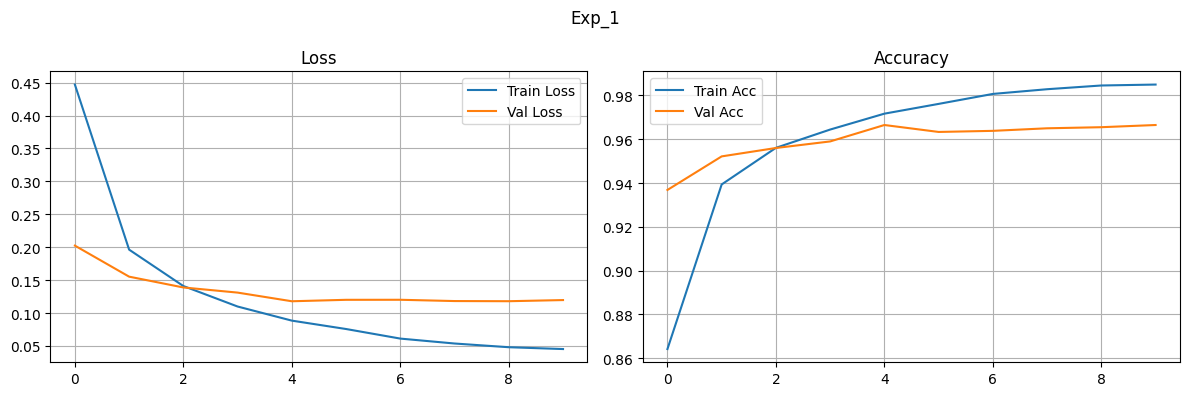

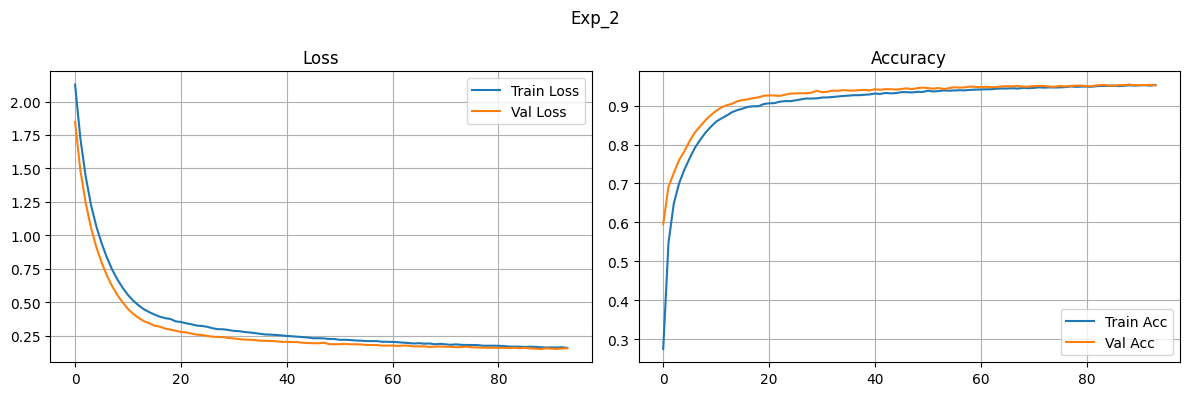

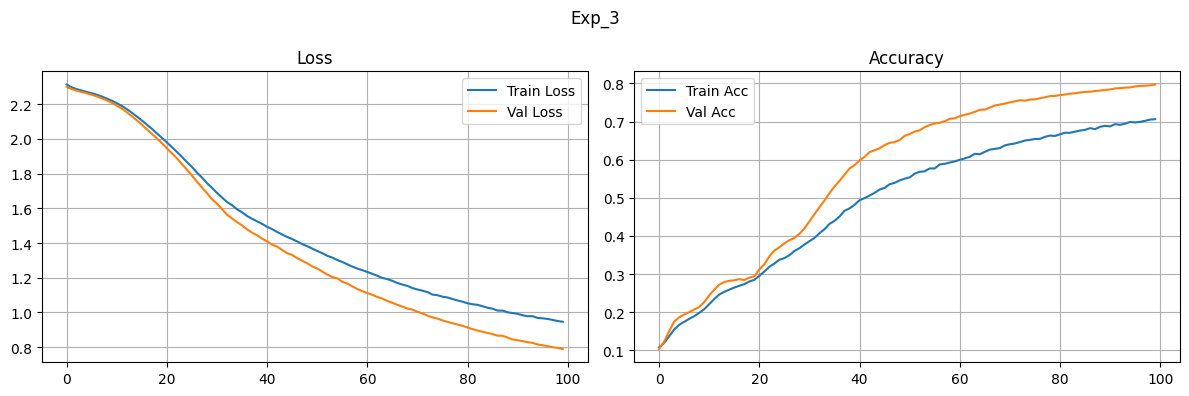

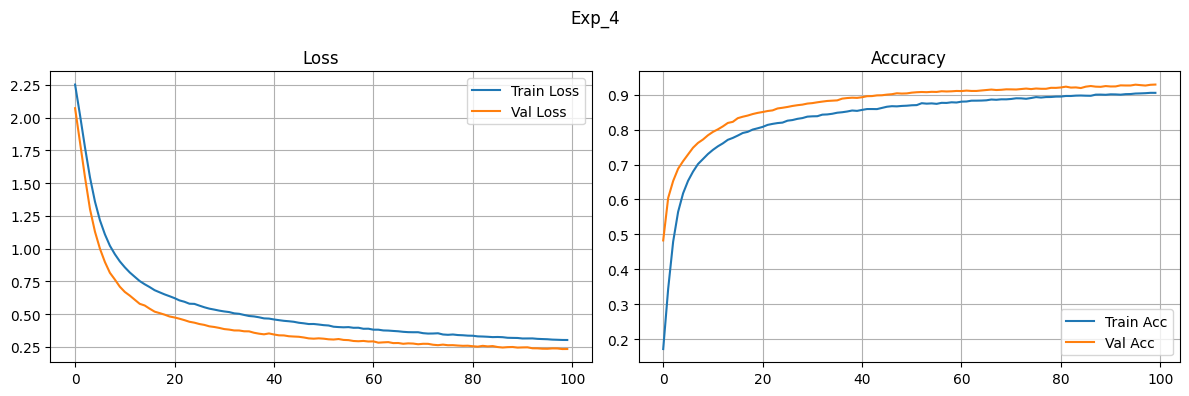

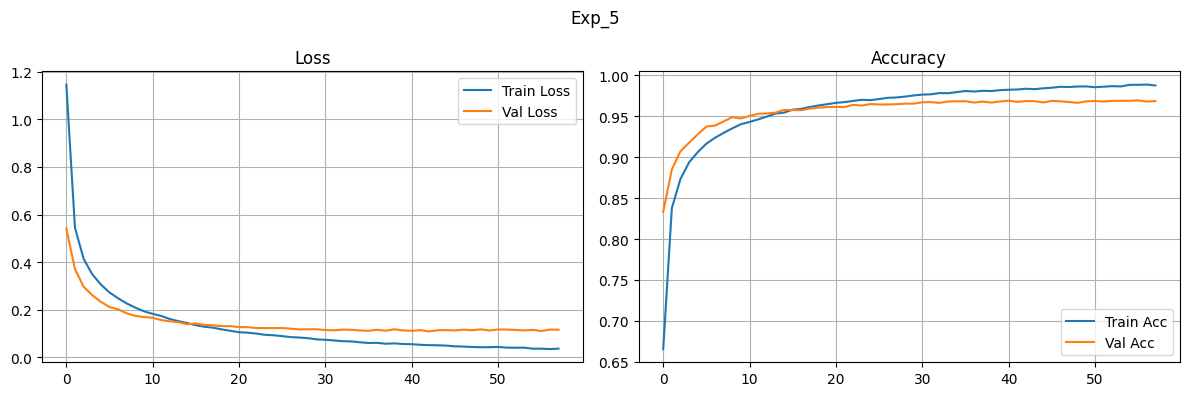

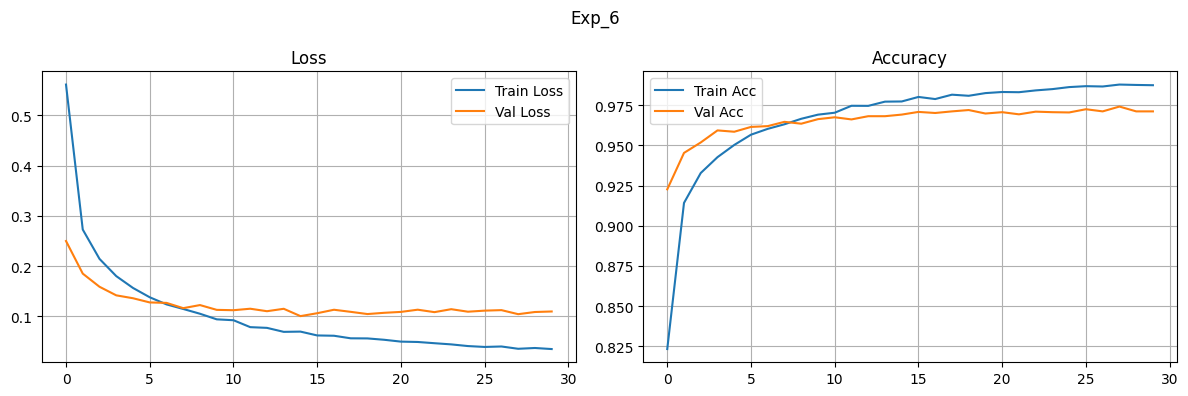

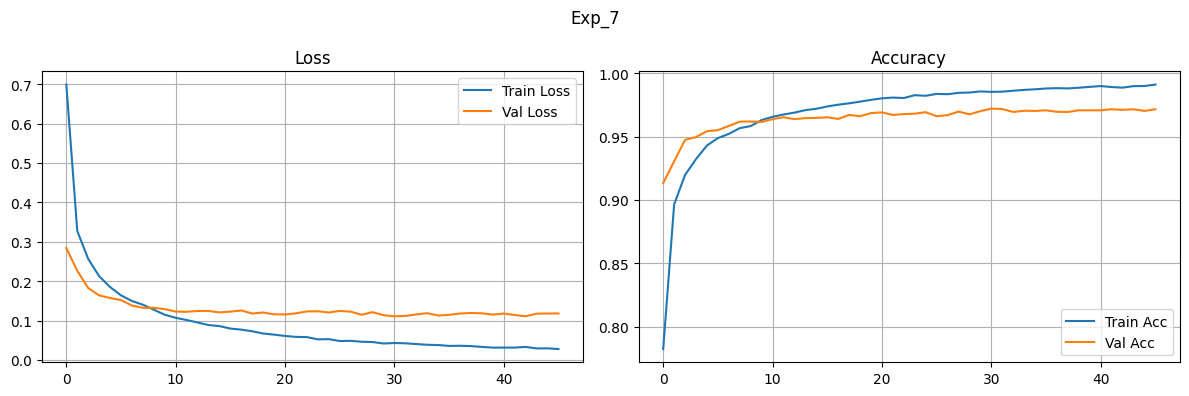

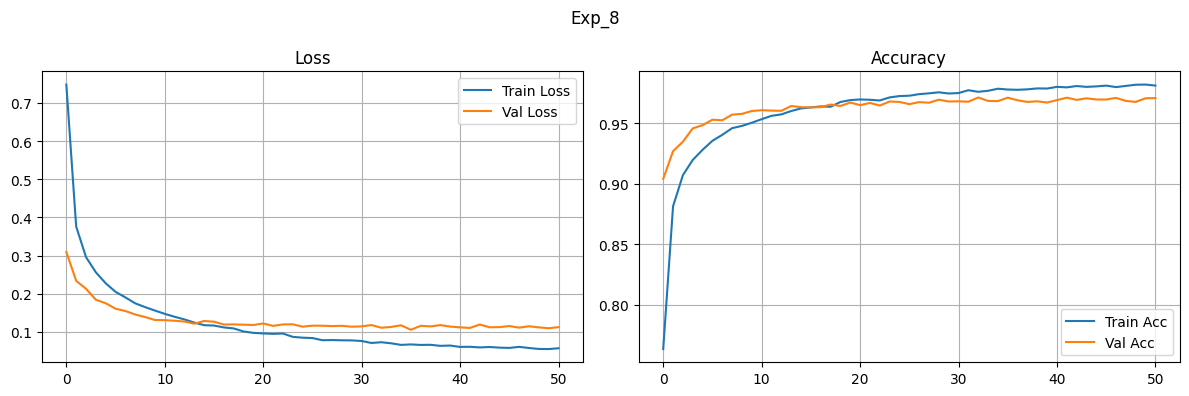

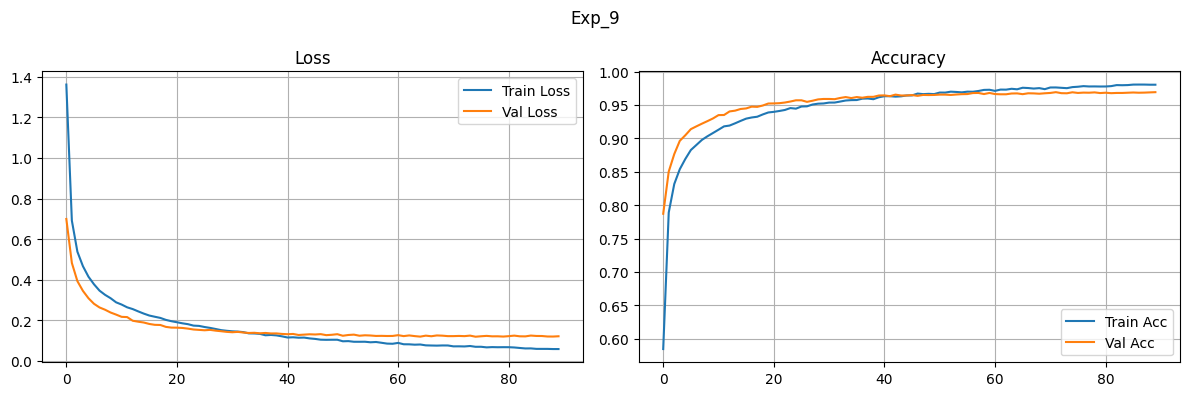

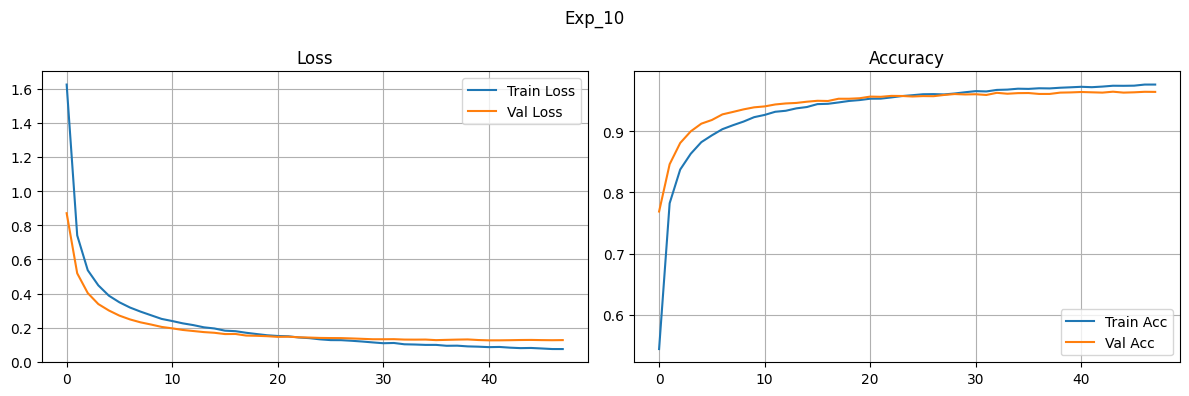

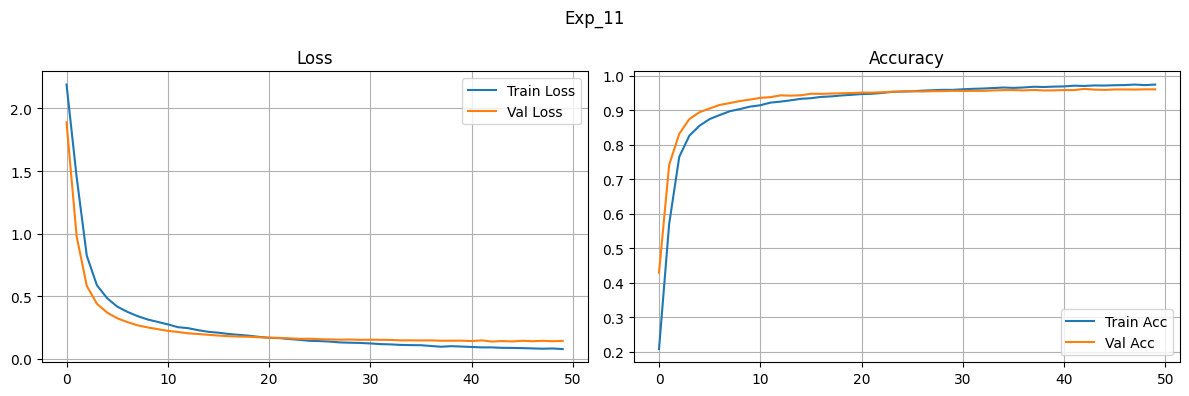

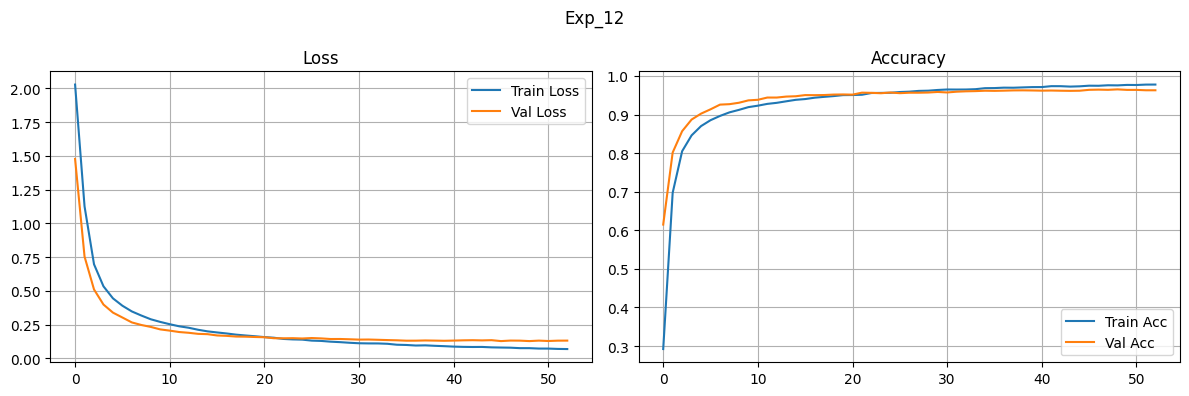

In [19]:
for experiment in experiments_data:
  history = experiment["trainer"].history
  figure = plt.figure(figsize=(12, 4))
  figure.suptitle(experiment["data"]["Run_Name"])
  plt.subplot(1, 2, 1)
  plt.plot(history["train_loss"], label="Train Loss")
  plt.plot(history["val_loss"],   label="Val Loss")
  plt.title("Loss")
  plt.legend()
  plt.grid(True)

  plt.subplot(1, 2, 2)
  plt.plot(history["train_acc"], label="Train Acc")
  plt.plot(history["val_acc"],   label="Val Acc")
  plt.title("Accuracy")
  plt.legend()
  plt.grid(True)

  plt.tight_layout()
  plt.show()




Visualized the test (do change)


Experiment: Exp_1


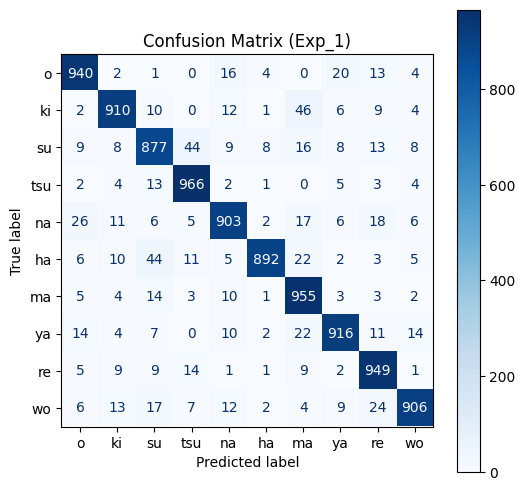

Classification report (Exp_1):
              precision    recall  f1-score   support

           0     0.9261    0.9400    0.9330      1000
           1     0.9333    0.9100    0.9215      1000
           2     0.8788    0.8770    0.8779      1000
           3     0.9200    0.9660    0.9424      1000
           4     0.9214    0.9030    0.9121      1000
           5     0.9759    0.8920    0.9321      1000
           6     0.8753    0.9550    0.9134      1000
           7     0.9376    0.9160    0.9267      1000
           8     0.9073    0.9490    0.9277      1000
           9     0.9497    0.9060    0.9273      1000

    accuracy                         0.9214     10000
   macro avg     0.9225    0.9214    0.9214     10000
weighted avg     0.9225    0.9214    0.9214     10000


Experiment: Exp_2


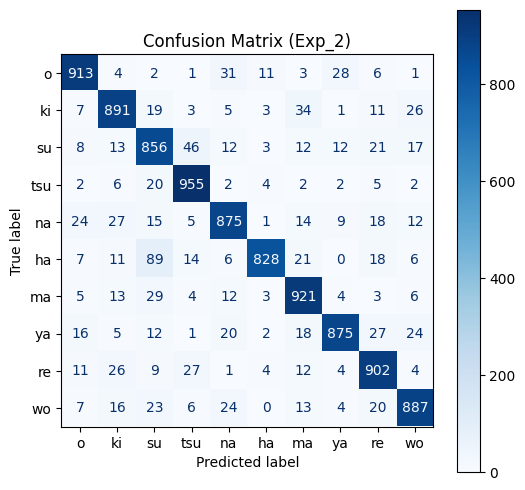

Classification report (Exp_2):
              precision    recall  f1-score   support

           0     0.9130    0.9130    0.9130      1000
           1     0.8804    0.8910    0.8857      1000
           2     0.7970    0.8560    0.8255      1000
           3     0.8992    0.9550    0.9263      1000
           4     0.8856    0.8750    0.8803      1000
           5     0.9639    0.8280    0.8908      1000
           6     0.8771    0.9210    0.8985      1000
           7     0.9318    0.8750    0.9025      1000
           8     0.8749    0.9020    0.8882      1000
           9     0.9005    0.8870    0.8937      1000

    accuracy                         0.8903     10000
   macro avg     0.8924    0.8903    0.8905     10000
weighted avg     0.8924    0.8903    0.8905     10000


Experiment: Exp_3


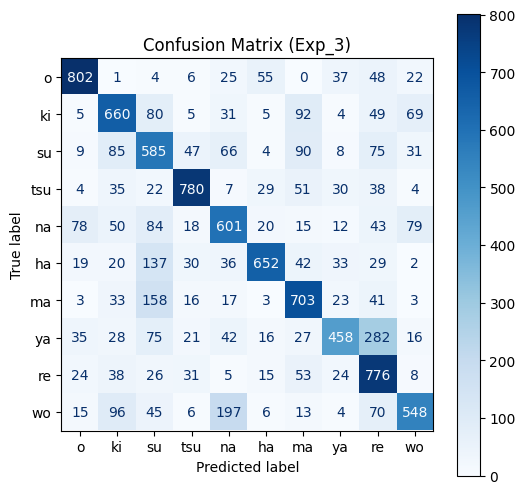

Classification report (Exp_3):
              precision    recall  f1-score   support

           0     0.8068    0.8020    0.8044      1000
           1     0.6310    0.6600    0.6452      1000
           2     0.4811    0.5850    0.5280      1000
           3     0.8125    0.7800    0.7959      1000
           4     0.5852    0.6010    0.5930      1000
           5     0.8099    0.6520    0.7224      1000
           6     0.6473    0.7030    0.6740      1000
           7     0.7235    0.4580    0.5609      1000
           8     0.5348    0.7760    0.6332      1000
           9     0.7008    0.5480    0.6150      1000

    accuracy                         0.6565     10000
   macro avg     0.6733    0.6565    0.6572     10000
weighted avg     0.6733    0.6565    0.6572     10000


Experiment: Exp_4


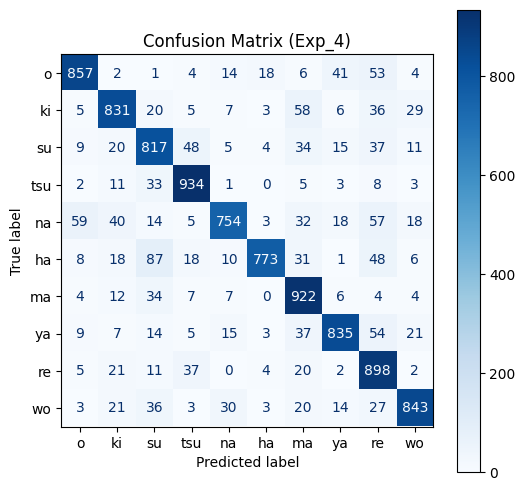

Classification report (Exp_4):
              precision    recall  f1-score   support

           0     0.8918    0.8570    0.8740      1000
           1     0.8454    0.8310    0.8381      1000
           2     0.7657    0.8170    0.7905      1000
           3     0.8762    0.9340    0.9042      1000
           4     0.8944    0.7540    0.8182      1000
           5     0.9531    0.7730    0.8537      1000
           6     0.7914    0.9220    0.8517      1000
           7     0.8874    0.8350    0.8604      1000
           8     0.7349    0.8980    0.8083      1000
           9     0.8959    0.8430    0.8686      1000

    accuracy                         0.8464     10000
   macro avg     0.8536    0.8464    0.8468     10000
weighted avg     0.8536    0.8464    0.8468     10000


Experiment: Exp_5


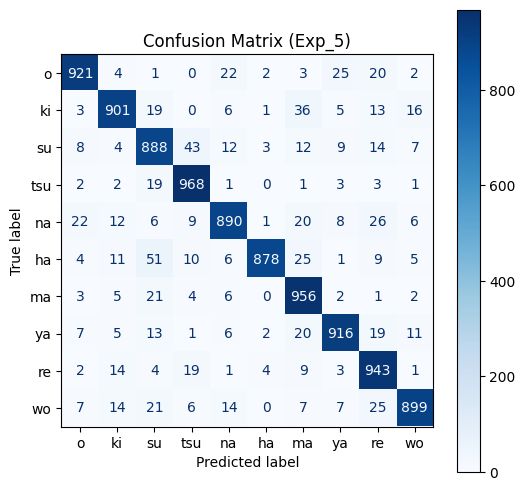

Classification report (Exp_5):
              precision    recall  f1-score   support

           0     0.9408    0.9210    0.9308      1000
           1     0.9270    0.9010    0.9138      1000
           2     0.8514    0.8880    0.8693      1000
           3     0.9132    0.9680    0.9398      1000
           4     0.9232    0.8900    0.9063      1000
           5     0.9854    0.8780    0.9286      1000
           6     0.8779    0.9560    0.9153      1000
           7     0.9356    0.9160    0.9257      1000
           8     0.8788    0.9430    0.9098      1000
           9     0.9463    0.8990    0.9221      1000

    accuracy                         0.9160     10000
   macro avg     0.9180    0.9160    0.9161     10000
weighted avg     0.9180    0.9160    0.9161     10000


Experiment: Exp_6


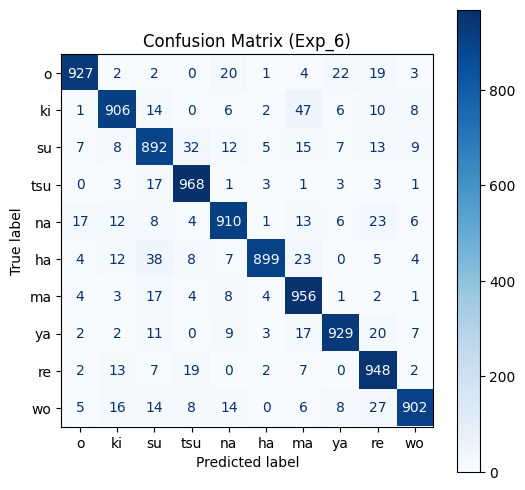

Classification report (Exp_6):
              precision    recall  f1-score   support

           0     0.9567    0.9270    0.9416      1000
           1     0.9273    0.9060    0.9165      1000
           2     0.8745    0.8920    0.8832      1000
           3     0.9281    0.9680    0.9476      1000
           4     0.9220    0.9100    0.9160      1000
           5     0.9772    0.8990    0.9365      1000
           6     0.8779    0.9560    0.9153      1000
           7     0.9460    0.9290    0.9374      1000
           8     0.8860    0.9480    0.9159      1000
           9     0.9565    0.9020    0.9285      1000

    accuracy                         0.9237     10000
   macro avg     0.9252    0.9237    0.9238     10000
weighted avg     0.9252    0.9237    0.9238     10000


Experiment: Exp_7


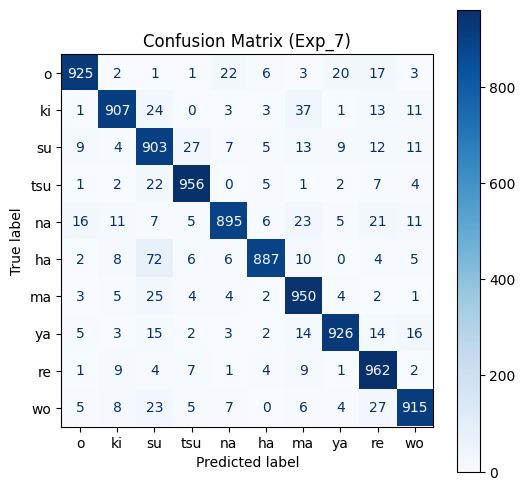

Classification report (Exp_7):
              precision    recall  f1-score   support

           0     0.9556    0.9250    0.9400      1000
           1     0.9458    0.9070    0.9260      1000
           2     0.8239    0.9030    0.8616      1000
           3     0.9437    0.9560    0.9498      1000
           4     0.9441    0.8950    0.9189      1000
           5     0.9641    0.8870    0.9240      1000
           6     0.8912    0.9500    0.9197      1000
           7     0.9527    0.9260    0.9391      1000
           8     0.8916    0.9620    0.9254      1000
           9     0.9346    0.9150    0.9247      1000

    accuracy                         0.9226     10000
   macro avg     0.9247    0.9226    0.9229     10000
weighted avg     0.9247    0.9226    0.9229     10000


Experiment: Exp_8


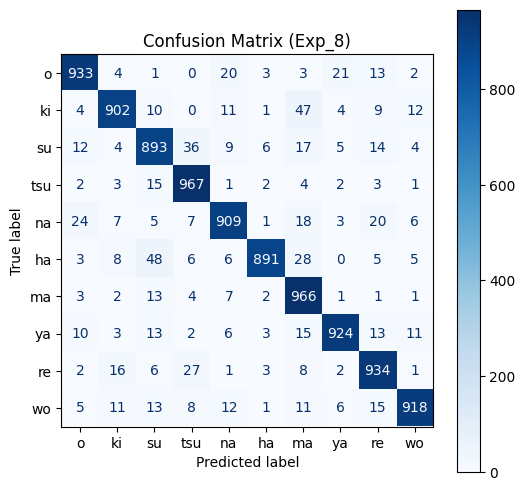

Classification report (Exp_8):
              precision    recall  f1-score   support

           0     0.9349    0.9330    0.9339      1000
           1     0.9396    0.9020    0.9204      1000
           2     0.8781    0.8930    0.8855      1000
           3     0.9149    0.9670    0.9402      1000
           4     0.9257    0.9090    0.9173      1000
           5     0.9759    0.8910    0.9315      1000
           6     0.8648    0.9660    0.9126      1000
           7     0.9545    0.9240    0.9390      1000
           8     0.9094    0.9340    0.9216      1000
           9     0.9553    0.9180    0.9363      1000

    accuracy                         0.9237     10000
   macro avg     0.9253    0.9237    0.9238     10000
weighted avg     0.9253    0.9237    0.9238     10000


Experiment: Exp_9


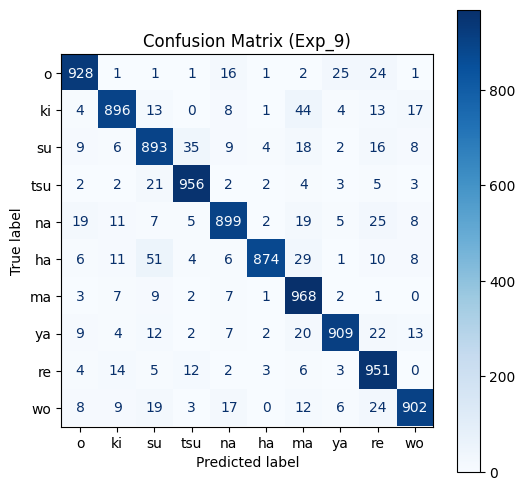

Classification report (Exp_9):
              precision    recall  f1-score   support

           0     0.9355    0.9280    0.9317      1000
           1     0.9324    0.8960    0.9138      1000
           2     0.8661    0.8930    0.8794      1000
           3     0.9373    0.9560    0.9465      1000
           4     0.9239    0.8990    0.9113      1000
           5     0.9820    0.8740    0.9249      1000
           6     0.8627    0.9680    0.9123      1000
           7     0.9469    0.9090    0.9276      1000
           8     0.8717    0.9510    0.9096      1000
           9     0.9396    0.9020    0.9204      1000

    accuracy                         0.9176     10000
   macro avg     0.9198    0.9176    0.9178     10000
weighted avg     0.9198    0.9176    0.9178     10000


Experiment: Exp_10


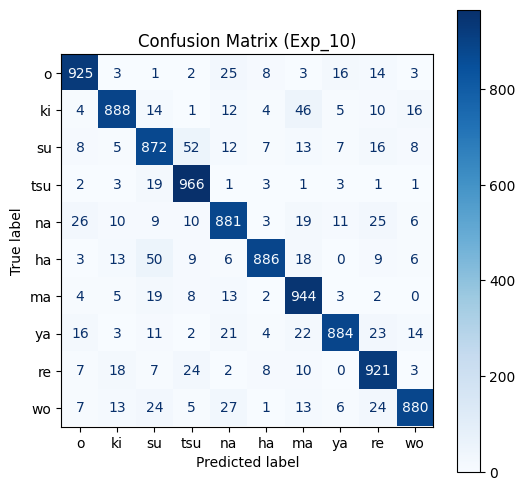

Classification report (Exp_10):
              precision    recall  f1-score   support

           0     0.9232    0.9250    0.9241      1000
           1     0.9240    0.8880    0.9057      1000
           2     0.8499    0.8720    0.8608      1000
           3     0.8953    0.9660    0.9293      1000
           4     0.8810    0.8810    0.8810      1000
           5     0.9568    0.8860    0.9200      1000
           6     0.8669    0.9440    0.9038      1000
           7     0.9455    0.8840    0.9137      1000
           8     0.8813    0.9210    0.9007      1000
           9     0.9392    0.8800    0.9086      1000

    accuracy                         0.9047     10000
   macro avg     0.9063    0.9047    0.9048     10000
weighted avg     0.9063    0.9047    0.9048     10000


Experiment: Exp_11


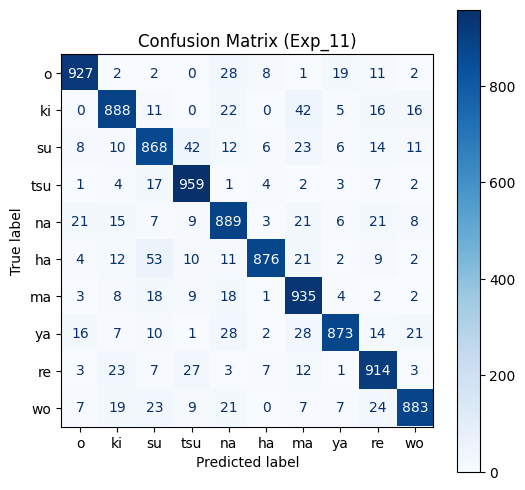

Classification report (Exp_11):
              precision    recall  f1-score   support

           0     0.9364    0.9270    0.9317      1000
           1     0.8988    0.8880    0.8934      1000
           2     0.8543    0.8680    0.8611      1000
           3     0.8996    0.9590    0.9284      1000
           4     0.8606    0.8890    0.8746      1000
           5     0.9658    0.8760    0.9187      1000
           6     0.8562    0.9350    0.8939      1000
           7     0.9428    0.8730    0.9065      1000
           8     0.8857    0.9140    0.8996      1000
           9     0.9295    0.8830    0.9056      1000

    accuracy                         0.9012     10000
   macro avg     0.9030    0.9012    0.9013     10000
weighted avg     0.9030    0.9012    0.9013     10000


Experiment: Exp_12


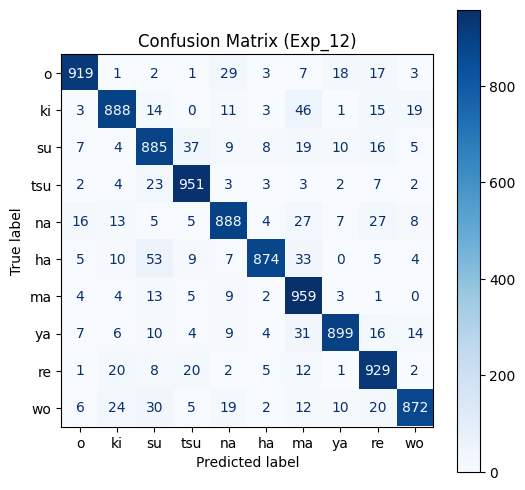

Classification report (Exp_12):
              precision    recall  f1-score   support

           0     0.9474    0.9190    0.9330      1000
           1     0.9117    0.8880    0.8997      1000
           2     0.8485    0.8850    0.8664      1000
           3     0.9171    0.9510    0.9337      1000
           4     0.9006    0.8880    0.8943      1000
           5     0.9626    0.8740    0.9161      1000
           6     0.8346    0.9590    0.8925      1000
           7     0.9453    0.8990    0.9216      1000
           8     0.8822    0.9290    0.9050      1000
           9     0.9386    0.8720    0.9041      1000

    accuracy                         0.9064     10000
   macro avg     0.9089    0.9064    0.9066     10000
weighted avg     0.9089    0.9064    0.9066     10000



In [20]:

from sklearn.metrics import ConfusionMatrixDisplay

# Define KMNIST Class Names
class_names = ['o', 'ki', 'su', 'tsu', 'na', 'ha', 'ma', 'ya', 're', 'wo']

for experiment in experiments_data:
    trainer = experiment["trainer"]
    test_loader = experiment["test_loader"]
    run_name = experiment["data"]["Run_Name"]

    print(f"\nExperiment: {run_name}")

    # Get predictions
    preds, targets = trainer.predict_all(test_loader)

    # Plot Confusion Matrix
    cm = confusion_matrix(targets, preds)
    
    plt.figure(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    
    # values_format='d' shows integers (counts) instead of scientific notation
    disp.plot(cmap='Blues', values_format='d', ax=plt.gca(), colorbar=True)
    
    plt.title(f"Confusion Matrix ({run_name})")
    plt.show()

    print(f"Classification report ({experiment["data"]["Run_Name"]}):")
    print(classification_report(targets, preds, digits=4))